# View rain gauge data
This notebook aims to visualize some aspects of the real rain gauge data.

In [1]:
import pandas as pd
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm

import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from shapely.geometry import Polygon, MultiPolygon
from pyresample import geometry, load_area

In [2]:
f = open('../path_to_data.txt', "r")
path_to_dataset = os.path.join(f.readline().rstrip("\n"))
f.close() 

In [3]:
metadata = pd.read_pickle(os.path.join(path_to_dataset, 'real_rain_gauge_data', 'general_rain_gauge_info.pckl'))
filepath = os.path.join(path_to_dataset, 'real_rain_gauge_data', 'csv_formatado')

### Example

In [4]:
df = pd.read_csv(os.path.join(filepath, metadata.filename[0]), delimiter = ',', header=0)
print(df.tail()) 

        DATA_UTC   00   01   02    03    04   05   06   07   08  ...   14  \
4527  2020-12-27  0.2  2.4  0.8  18.8  10.8  6.6  5.6  1.2  0.4  ...  0.0   
4528  2020-12-28  0.0  0.0  0.2   0.0   0.0  0.0  0.0  0.0  0.0  ...  0.0   
4529  2020-12-29  0.0  0.0  0.0   0.0   0.0  0.0  0.2  1.4  0.0  ...  0.0   
4530  2020-12-30  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  ...  0.0   
4531  2020-12-31  1.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.2  ...  1.4   

       15   16   17   18   19   20   21   22    23  
4527  0.0  0.0  0.0  0.2  0.0  0.0  0.4  1.8   0.4  
4528  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  
4529  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  
4530  0.0  0.0  0.0  0.0  0.0  2.6  0.0  0.0  19.0  
4531  0.2  0.8  0.0  0.0  0.0  0.0  0.0  0.2   0.6  

[5 rows x 25 columns]


In [5]:
df = pd.read_csv(os.path.join(filepath, 'MG_S122_F_W59.82388888_S19.97999999.csv'), delimiter = ',', header=0)
df2 = df.drop('DATA_UTC', axis=1)
print(np.sum(df2.isnull()))

00    566
01    566
02    566
03    568
04    567
05    568
06    567
07    567
08    567
09    567
10    568
11    568
12    568
13    569
14    569
15    570
16    566
17    565
18    565
19    564
20    564
21    563
22    566
23    566
dtype: int64


### Check amount of nans in relevant data

In [6]:
num_nans_list = []
num_tots_list = []
for month in range(4,13):
    print(month)
    num_nans = 0
    num_tots = 0
    st = '2020-'+str(month)+'-1'
    et = '2020-'+str(month+1)+'-1'
    if month >= 12:
        et = '2021-'+str(month+1-12)+'-1'
    print(st)
    print(et)
    for f in metadata.filename:
        #print(f)
        df = pd.read_csv(os.path.join(filepath, f), delimiter = ',', header=0)
        df.DATA_UTC = pd.to_datetime(df.DATA_UTC, format='%Y-%m-%d')
        mask = (df.DATA_UTC >= st)*(df.DATA_UTC < et)
        nf = df.loc[mask]
        num_nans += nf.isnull().values.sum()
        num_tots += nf.shape[0]*24
    num_nans_list.append(num_nans)
    num_tots_list.append(num_tots)


4
2020-4-1
2020-5-1


/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


5
2020-5-1
2020-6-1
6
2020-6-1
2020-7-1
7
2020-7-1
2020-8-1
8
2020-8-1
2020-9-1
9
2020-9-1
2020-10-1
10
2020-10-1
2020-11-1
11
2020-11-1
2020-12-1
12
2020-12-1
2021-1-1


In [7]:
print(num_nans_list)
print(num_tots_list)
print([n/t for n,t in zip(num_nans_list, num_tots_list)])
print([t-n for n,t in zip(num_nans_list, num_tots_list)])

[112841, 135711, 122271, 133268, 139969, 144248, 169328, 183473, 151323]
[423360, 437472, 423360, 437472, 437472, 423360, 437472, 423360, 437472]
[0.266536753590325, 0.3102164252797893, 0.2888109410430839, 0.3046320678809158, 0.31994961963279933, 0.34072184429327285, 0.3870602004242557, 0.4333734882842026, 0.3459032806671056]
[310519, 301761, 301089, 304204, 297503, 279112, 268144, 239887, 286149]


### Check specific events

In [8]:
#mydate = ['2020-07-06', '2020-07-08'] # Rio Grande do Sul
#mydate = ['2020-11-02', '2020-11-03'] # Sanharo in Pernambuco
#mydate = ['2020-12-16', '2020-12-18'] # Presidente Getúlio
mydate = ['2020-12-22', '2020-12-23'] # Xerém (BEST)
#mydate = ['2020-03-03', '2020-03-03'] # Guarujá
#mydate = ['2020-11-26', '2020-11-26'] # Sao Carlos

In [9]:
#lonlats_mask = (lonlats_df['lon'] < -53)*(lonlats_df['lon'] > -55)*(lonlats_df['lat'] < -28)*(lonlats_df['lat'] > -30)
#lonlats_mask = (lonlats_df['lon'] < -35.5)*(lonlats_df['lon'] > -37.5)*(lonlats_df['lat'] < -7.5)*(lonlats_df['lat'] > -9.5)
#lonlats_mask = (lonlats_df['lon'] < -48.5)*(lonlats_df['lon'] > -50.5)*(lonlats_df['lat'] < -26)*(lonlats_df['lat'] > -27.5)
lonlats_mask = (metadata['lon'] < -43)*(metadata['lon'] > -43.5)*(metadata['lat'] < -22)*(metadata['lat'] > -23)
#lonlats_mask = (lonlats_df['lon'] < -46)*(lonlats_df['lon'] > -46.6)*(lonlats_df['lat'] < -23)*(lonlats_df['lat'] > -24.5)
#lonlats_mask = (lonlats_df['lon'] < -47)*(lonlats_df['lon'] > -48)*(lonlats_df['lat'] < -22)*(lonlats_df['lat'] > -23)

/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


In [10]:
lonlats_inds = metadata[lonlats_mask].index
print(lonlats_inds)
print(metadata[lonlats_mask])

Int64Index([429, 435, 440, 442, 444, 449, 450], dtype='int64')
                                       filename        lon        lat state  \
429    RJ_A603_33_W43.28222221_S22.58972221.csv -43.282222 -22.589722    RJ   
435  RJ_A610_1777_W43.29138888_S22.48166666.csv -43.291389 -22.481667    RJ   
440    RJ_A621_45_W43.41111111_S22.86083333.csv -43.411111 -22.860833    RJ   
442   RJ_A625_305_W43.20861111_S22.09833333.csv -43.208611 -22.098333    RJ   
444     RJ_A627_6_W43.10194444_S22.86749999.csv -43.101944 -22.867500    RJ   
449    RJ_A636_20_W43.40277777_S22.93972221.csv -43.402778 -22.939722    RJ   
450    RJ_A652_42_W43.19027777_S22.98833333.csv -43.190278 -22.988333    RJ   

    region   col   row  
429     SE  2097  1940  
435     SE  2097  1937  
440     SE  2092  1946  
442     SE  2101  1928  
444     SE  2098  1946  
449     SE  2092  1948  
450     SE  2096  1949  


In [11]:
for i in lonlats_inds:
    print('\n', i)
    myfile = metadata.filename[i]
    print(myfile)
    df = pd.read_csv(os.path.join(filepath, myfile), delimiter = ',', header=0)
    df.DATA_UTC = pd.to_datetime(df.DATA_UTC, format='%Y-%m-%d')
    mask = (df.DATA_UTC >= mydate[0])*(df.DATA_UTC <= mydate[1])
    print(df.loc[mask].T)

/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(



 429
RJ_A603_33_W43.28222221_S22.58972221.csv
                         6637                 6638
DATA_UTC  2020-12-22 00:00:00  2020-12-23 00:00:00
00                        0.0                  1.2
01                        0.0                  0.6
02                        0.0                  0.0
03                        0.0                  0.0
04                        0.0                  1.8
05                        0.0                  0.4
06                        0.0                  0.0
07                        0.0                  0.6
08                        0.0                  0.0
09                        0.0                  0.6
10                        0.0                  0.4
11                        0.0                  0.8
12                        0.0                  1.2
13                        0.0                  0.0
14                        0.0                  0.0
15                        0.0                  0.4
16                        0.8      

/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '

### Visualize coverage

/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


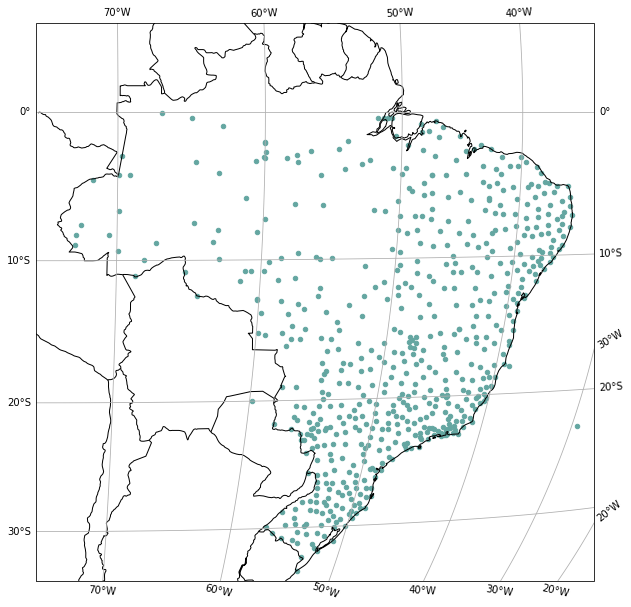

In [12]:
import sys
sys.path.append('../visualize')
import plot_dataset_funs
from plot_dataset_funs import initial_load

areas_filepath =  '../dataset/downloads/files/areas.yaml'
initial_load(areas_filepath)
area_def_region = plot_dataset_funs.area_def.copy(area_extent = plot_dataset_funs.region_corners,
                                                  height = plot_dataset_funs.region_height, 
                                                  width = plot_dataset_funs.region_width)
crs = area_def_region.to_cartopy_crs()
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize = (10,11))

ax.scatter(x=metadata.lon, y=metadata.lat, transform=ccrs.PlateCarree(), s=20, color='#64a6a1')

ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.BORDERS)
ax.set_global()
#ax.title.set_text(plot_title)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


Text(0, 0.5, 'y')

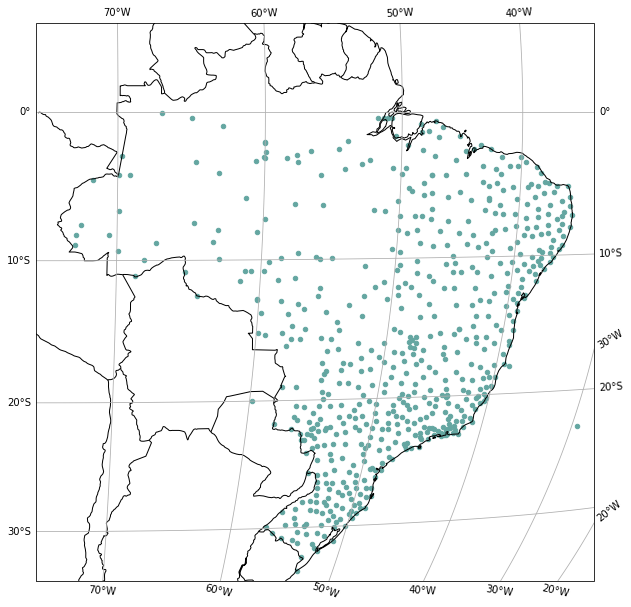

In [13]:
ext_ind_extent = [1344, 2217, 2368, 1193]
projcoords_x, projcoords_y =  plot_dataset_funs.area_def.get_proj_vectors()
ext_area_extent = [projcoords_x[ext_ind_extent[0]], projcoords_y[ext_ind_extent[1]], 
                   projcoords_x[ext_ind_extent[2]], projcoords_y[ext_ind_extent[3]]]

area_def_ext_region = plot_dataset_funs.area_def.copy(area_extent = ext_area_extent,
                                                  height = 1024, 
                                                  width = 1024)
crs = area_def_ext_region.to_cartopy_crs()
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize = (10,11))

ax.scatter(x=metadata.lon, y=metadata.lat, transform=ccrs.PlateCarree(), s=20, color='#64a6a1')

ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.BORDERS)
ax.set_global()
#ax.title.set_text(plot_title)
ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.show()
#plt.savefig('../plots/thesis/raingaugesmap.pdf', bbox_inches='tight')

In [14]:
import sys
sys.path.append('../visualize')
import plotTestSetup as setup

/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


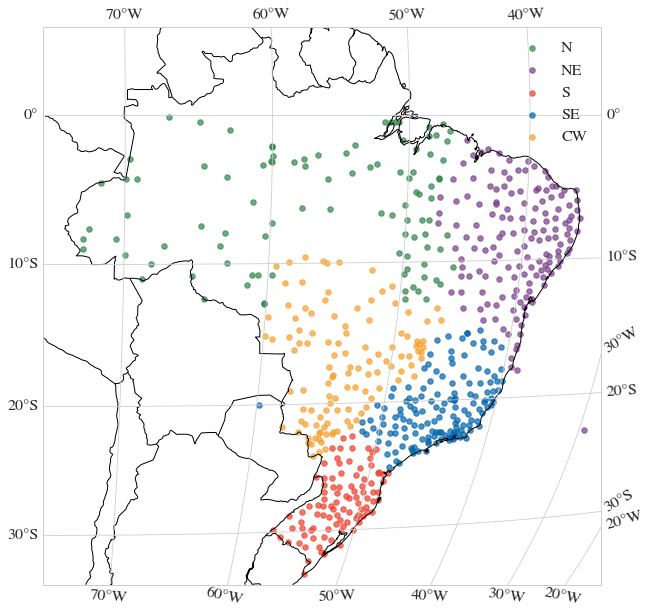

In [15]:
ext_ind_extent = [1344, 2217, 2368, 1193]
projcoords_x, projcoords_y =  plot_dataset_funs.area_def.get_proj_vectors()
ext_area_extent = [projcoords_x[ext_ind_extent[0]], projcoords_y[ext_ind_extent[1]], 
                   projcoords_x[ext_ind_extent[2]], projcoords_y[ext_ind_extent[3]]]

area_def_ext_region = plot_dataset_funs.area_def.copy(area_extent = ext_area_extent,
                                                  height = 1024, 
                                                  width = 1024)
crs = area_def_ext_region.to_cartopy_crs()
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize = (10,11))

regs = ['N', 'NE', 'S', 'SE', 'CW']
cols = ['#2f8349', '#783e8b', '#ee3d2a', '#0064ac', '#f79f2b']
for i in range(len(regs)):
    reg = regs[i]
    ax.scatter(x=metadata.loc[metadata.region==reg].lon, y=metadata.loc[metadata.region==reg].lat,
               transform=ccrs.PlateCarree(), s=30, alpha=0.7,
               color=cols[i], label=reg
              )

ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.BORDERS)
ax.set_global()
#ax.title.set_text(plot_title)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
#plt.show()
#plt.savefig('../plots/thesis/raingaugesmap.pdf', bbox_inches='tight')

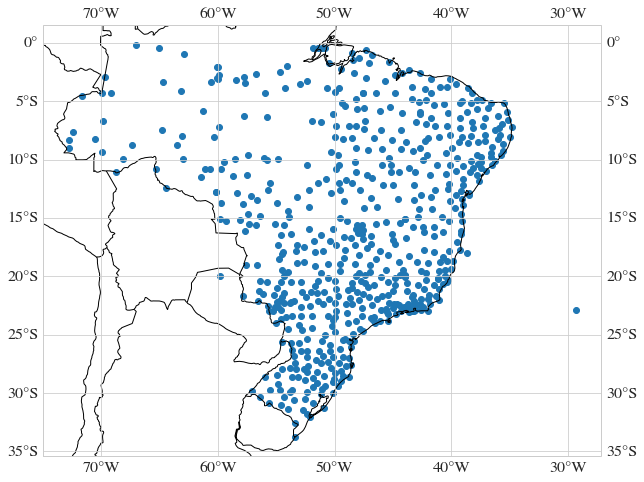

In [16]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize = (10,11))
ax.scatter(x=metadata.lon, y=metadata.lat,  transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.BORDERS)